<a href="https://colab.research.google.com/github/Omowumieru/FDSfE_OErukubami/blob/main/HW5/GIS%20Data%20Manipulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW5 - Reproducible Spatial Data Analysis with pandas
Exploratory spatial data analysis of CitiBike data using pysal and geopandas

> **By Emmanuel Chinkaka**

> **University of Delaware**

> **Department of Geography and Spatial Sciences**

Use this notebook below for reference: 

https://github.com/EmmanuelChinkaka/W23-GEOG271/blob/main/Class_Demo/Analysis_CitiBike.ipynb

# 0 Install geospatial libraries first ... Refer to these below:

!pip install geopandas

!pip install folium

!apt install python3-rtree 



In [30]:
# Installing geopandas and folium
!pip install geopandas
!pip install folium
!apt install python3-rtree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.9.4-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


## 0.1 Import initial libraries

In [31]:
#importing libraries

# interacting with hosting site
import urllib3
from bs4 import BeautifulSoup

# getting and reading files
import os
import glob
import pandas as pd

# geospatial analysis 
from shapely.geometry import Point, LineString
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster

# Need to use matplotlib colormaps to map colors to variables' values

from matplotlib import cm

import matplotlib.pyplot as plt

# 1 Working with a Shape File of Census Tracts

### 1.1 Loading Census Tract GeoJSON File


In [32]:
ct_shape = gpd.read_file("https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=GeoJSON")

In [33]:
ct_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 2165 entries, 0 to 2164
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      2165 non-null   object  
 1   shape_area   2165 non-null   object  
 2   ntaname      2165 non-null   object  
 3   shape_leng   2165 non-null   object  
 4   boro_name    2165 non-null   object  
 5   puma         2165 non-null   object  
 6   ct2010       2165 non-null   object  
 7   boro_code    2165 non-null   object  
 8   cdeligibil   2164 non-null   object  
 9   boro_ct2010  2165 non-null   object  
 10  ctlabel      2165 non-null   object  
 11  geometry     2165 non-null   geometry
dtypes: geometry(1), object(11)
memory usage: 203.1+ KB


## 1.2 Coordinate systems, projections, and transformations : 

**What is the coordinate system for the data?**

In [34]:
#Checking the coordinate refernce system for the geodataframe ct_shape
ct_shape.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### Visualize the Census Tract boundaries colored by boroughs

the file you read in into a geodataframe, which I will call generically ```gpd``` in these instructions, contains the "boro_code" column. To color by a column value (and the column can be numerical or categorical) you pass the column name to ```gdp.plot``` as
```gdp.plot(column="columnName")```

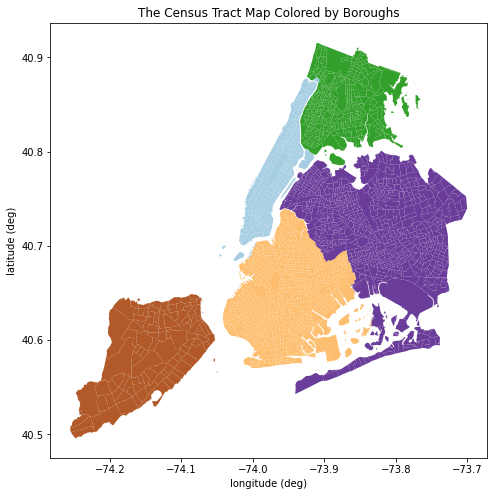

In [35]:
#Geo-visualizating the census tracts data
f, ax = plt.subplots(figsize=(8,8))
ax.set_xlabel("longitude (deg)")
ax.set_ylabel("latitude (deg)")
ct_shape.plot(column='boro_code', alpha=1, linewidth=0.5,
              ax=ax, cmap='Paired')
plt.title("The Census Tract Map Colored by Boroughs");

### Measure Areas

As discussed in class, you cannot use coordinates in latitude and longitude degree units to measure areas of polygons: you need first to project on a plane.

* Convert the coordinates of  your geodataframe, here referred to  as gpd, to a projected EPSG:2263 which is coordinated in feet, instead of lat long degrees. centered near NYC

  use 

```gpd.to_crs("EPSG:2263")```

* Extract the area of each gemetry : the geometry column has many relevant methods. use (as we did in class)

```gpd.geometry.area```

* Create a new column in your dataframe called "shape_areami2" and set it equal to the area of the polygon in miles squared. the feet to miles conversion is here 
https://www.google.com/search?sxsrf=ALeKk03B4ThQrJJXpFzoCrgRfrJ1nByPMg%3A1600870977934&ei=QVprX9muOIOl_QbOtaOwCQ&q=feet+to+mile&oq=feet+to+mile&gs_lcp=CgZwc3ktYWIQAzIICAAQsQMQkQIyAggAMgIIADICCAAyAggAMgIIADICCAAyAggAMgIIADICCAA6BAgAEEc6BAgjECc6BQgAELEDOgoIABCxAxAUEIcCUM_1AVjK-AFgzPoBaABwAngAgAFkiAHvApIBAzMuMZgBAKABAaoBB2d3cy13aXrIAQjAAQE&sclient=psy-ab&ved=0ahUKEwiZ0-GPvf_rAhWDUt8KHc7aCJYQ4dUDCA0&uact=5


* Calculate the total area of NYC in miles squared. 

* On epsg.io  look up the EPSG:2263. What is the accuracy when this projection is used in NYC?



**As expalined above, the CRS of the data is in degrees, thus not possible to project onto a 2D space. This requires a tranformation to 2D in order to be able to make any sensible dimensional meausurements. This is done below:**

In [36]:
#Converting the degrees into US feet. 
ct_shape = ct_shape.to_crs("EPSG:2263")
ct_shape.crs


<Derived Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

**Now, the data is in feet and Now plot the data in feet**

In [37]:
ct_shape.geometry.area

0       2.497010e+06
1       1.906016e+06
2       1.860993e+06
3       1.864600e+06
4       1.890907e+06
            ...     
2160    7.595191e+06
2161    2.332264e+06
2162    2.391962e+06
2163    1.253235e+06
2164    2.024543e+06
Length: 2165, dtype: float64

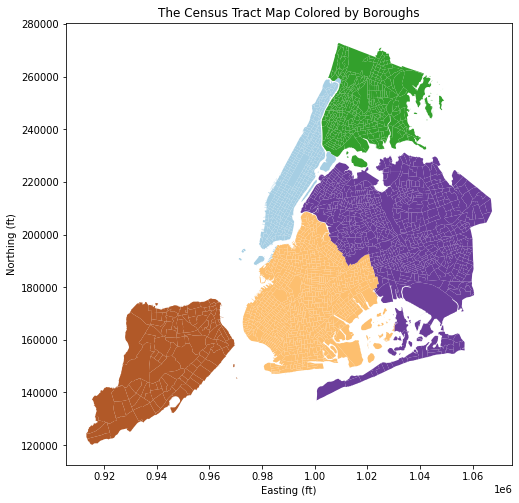

In [38]:
#Geo-visualizating the census tracts data in Feet

b, ax = plt.subplots(figsize=(8,10))
ax.set_ylabel("Northing (ft)")
ax.set_xlabel("Easting (ft)")
ct_shape.plot(column='boro_code', alpha=1, linewidth=0.8,
              ax=ax, cmap='Paired')
plt.title("The Census Tract Map Colored by Boroughs");



**Now we can be able to measure the area of each geometry object in square miles**

**Convertion factor from area feet to miles is 1: 3.587e-8**

**We create a new column called "shape_areami2" in the data. This column returns the areas of each geometry in the city in square miles**

In [39]:
#Creating a new column in the data and convert the area geometry into square miles
ct_shape["shape_areami2"] = ct_shape.geometry.area * 3.587e-8
ct_shape

,ntacode,shape_area,ntaname,shape_leng,boro_name,puma,ct2010,boro_code,cdeligibil,boro_ct2010,ctlabel,geometry,shape_areami2
0,SI22,2497009.71359,West New Brighton-New Brighton-St. George,7729.01679383,Staten Island,3903,000900,5,E,5000900,9,"MULTIPOLYGON (((962269.126 173705.500, 962288....",0.089568
1,MN19,1906016.47074,Turtle Bay-East Midtown,5534.20030845,Manhattan,3808,009800,1,I,1009800,98,"MULTIPOLYGON (((994133.507 214848.898, 994005....",0.068369
2,MN17,1860992.68163,Midtown-Midtown South,5687.80243891,Manhattan,3807,010200,1,I,1010200,102,"MULTIPOLYGON (((992216.539 216507.687, 992091....",0.066754
3,MN17,1864600.43538,Midtown-Midtown South,5693.03636707,Manhattan,3807,010400,1,I,1010400,104,"MULTIPOLYGON (((991325.882 217001.689, 991199....",0.066883
4,MN17,1890907.25105,Midtown-Midtown South,5699.86064037,Manhattan,3807,011300,1,I,1011300,113,"MULTIPOLYGON (((988650.277 214286.402, 988517....",0.067827
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2160,QN72,7595222.96542,Steinway,15137.0331772,Queens,4101,031700,4,I,4031700,317,"MULTIPOLYGON (((1014204.890 222262.789, 101422...",0.272440
2161,BK95,2332264.0357,Erasmus,6106.75671502,Brooklyn,4010,079200,3,E,3079200,792,"MULTIPOLYGON (((997667.512 173566.353, 997398....",0.083658
2162,BK95,2391961.65558,Erasmus,6265.76293199,Brooklyn,4010,079400,3,I,3079400,794,"MULTIPOLYGON (((997556.443 174916.108, 997380....",0.085800
2163,BK79,1253234.96366,Ocean Hill,6138.95805805,Brooklyn,4007,036502,3,E,3036502,365.02,"MULTIPOLYGON (((1011245.231 185499.827, 101121...",0.044954


**Display the column values of square miles created above**

In [40]:
#Displaying the column values of square miles created above
ct_shape_sqmile = ct_shape["shape_areami2"]
ct_shape_sqmile

0       0.089568
1       0.068369
2       0.066754
3       0.066883
4       0.067827
          ...   
2160    0.272440
2161    0.083658
2162    0.085800
2163    0.044954
2164    0.072620
Name: shape_areami2, Length: 2165, dtype: float64

In [41]:
#Calculating the total area in Square miles by adding all the areas of the geometry from the column shape_areami2 from the data



NYC_Area = ct_shape_sqmile.sum()
NYC_Area
print ('total NYC land area: {:.0f} (mi^2)'.format(NYC_Area)) # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302 (mi^2)


**END OF HW5**